In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import sqlite3
import scrapbook as sb
plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

/opt/homebrew/Caskroom/miniforge/base/envs/mfe-preprogram/lib/python3.8/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [3]:
def series_plot(data,ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)
    ax.legend(loc="best")

In [4]:
db = "sqlite:///data/data.db"
token = "BTC"
start_date = '2021-12-01'
end_date = '2021-12-08'

In [5]:
# Parameters
start_date = "2021-11-29"
end_date = "2021-12-12"
token = "COMP"
db = "sqlite:///data/data.db"


In [6]:
df = pd.read_sql(
f'''
SELECT *
FROM ohlc
WHERE
    token = '{token}'
    AND ts >= '{start_date}'
    AND ts <= '{end_date}'
''',db)

In [7]:
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts',inplace=True)
df['return'] = df['close']/df['close'].shift(1)-1 
df['vol'] = vol_ohlc(df)
peak_value = df['close'].cummax()
hourly_drawdown = df['close']/peak_value
df['maximum_drawdown'] = hourly_drawdown.cummin()

In [8]:
%%capture
fig,ax = plt.subplots(2,2)

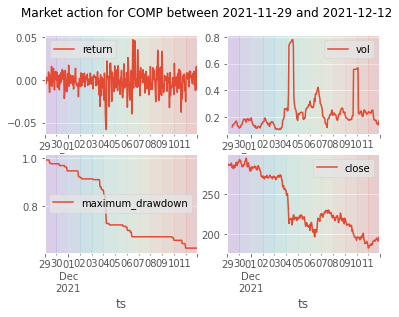

In [9]:
series_plot(df[['return']],ax=ax[0,0])
series_plot(df[['vol']],ax=ax[0,1])
series_plot(df[['maximum_drawdown']],ax=ax[1,0])
series_plot(df[['close']],ax=ax[1,1])
fig.suptitle(f'Market action for {token} between {start_date} and {end_date}')
fig

In [10]:
sb.glue('token',token)
sb.glue('start_date',start_date)
sb.glue('end_date',end_date)
sb.glue('df',df,encoder='pandas')